# <center>Modeling Empirical Stock Market Behavior Using a Hybrid Agent-Based Dynamical Systems Model</center>
### <center>Daniel A. Cline*, Grant T. Aguinaldo, and Christian Lemp</center>
<center>Department of Systems Science and Industrial Engineering</center>
<center>Binghamton University, Binghamton, NY, USA</center>
<center>∗dcline1@binghamton.edu</center>

<br>

Supporting code for:

Cline, Daniel A.; Aguinaldo, Grant T.; and Lemp, Christian (2022) "[Modeling Empirical Stock Market Behavior Using a Hybrid Agent-Based Dynamical Systems Model](https://orb.binghamton.edu/nejcs/vol4/iss2/1/)," Northeast Journal of Complex Systems (NEJCS): Vol. 4 : No. 2 , Article 1.

<br>

In [1]:
import numpy as np
from numpy import random

import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic
import statsmodels.graphics.tsaplots as sgt

import matplotlib.pyplot as plt
from matplotlib import gridspec
#%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')

## Historical Returns

We start by looking at 20 years (5000 trading days) of historical stock market (SPY) returns.

In [2]:
file = 'SPY.csv'

df = pd.read_csv(file)

df['Date'] = pd.to_datetime(df['Date'])
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1, inplace=True)
df.rename({'Adj Close': 'Price'}, axis=1, inplace=True)

r_hist = np.diff(np.log(df['Price']))
hist_size = len(r_hist)

df = df.iloc[1:] # remove first observation

df['Return'] = r_hist
df['ReturnAbs'] = np.abs(r_hist)
df['ReturnSq'] = np.square(r_hist)

#df = df.set_index('Date')

df.head()

,Date,Price,Return,ReturnAbs,ReturnSq
1,2001-03-05,83.945015,0.009100,0.009100,0.000083
2,2001-03-06,84.846786,0.010685,0.010685,0.000114
3,2001-03-07,85.452438,0.007113,0.007113,0.000051
4,2001-03-08,85.546677,0.001102,0.001102,0.000001
5,2001-03-09,83.016365,-0.030024,0.030024,0.000901


### Plot SPY Price and Returns

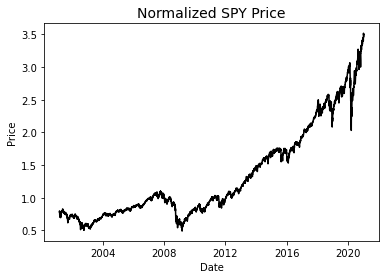

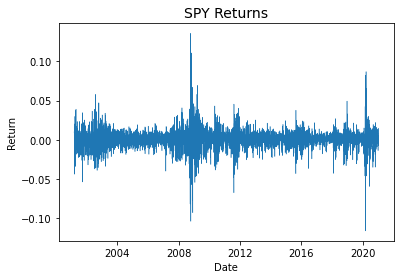

In [3]:
plt.plot(df['Date'], df['Price'] / df['Price'][2501], 'k')
plt.title('Normalized SPY Price', size=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.plot(df['Date'], df['Return'], linewidth=0.5)
plt.title('SPY Returns', size=14)
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

### ACF Plots

In [4]:
def plot_acfs(rvec, name = ''):

    sgt.plot_acf(rvec, lags=40, zero=True)
    plt.title('ACF of %s Returns' % name, size=14)
    plt.show()

    sgt.plot_acf(np.abs(rvec), lags=40, zero=True)
    plt.title('ACF of %s Absolute Returns' % name, size=14)
    plt.show()

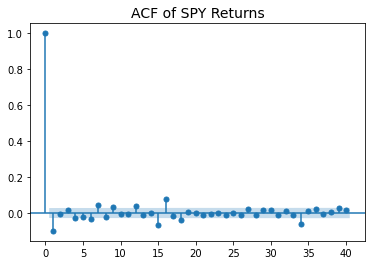

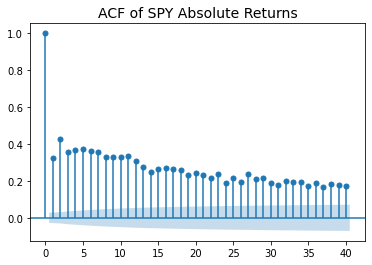

In [5]:
plot_acfs(df.Return, 'SPY')

### SPY Summary Statistics

In [6]:
def print_stats(rvec):

    mu = np.mean(rvec)
    sigma = np.std(rvec)
    sigma2 = np.var(rvec)
    skew = stats.skew(rvec)
    kurt = stats.kurtosis(rvec)
    rng = rvec.max() - rvec.min()

    print('Daily return statistics:')
    print('Mean:\t\t\t', mu)
    print('Std dev:\t\t', sigma)
    print('Variance:\t\t', sigma2)
    print('Skewness:\t\t', skew)
    print('Excess kurt:\t\t', kurt)
    print('Range:\t\t\t', rng)
    print()

    mu_a = mu * 252
    sigma_a = sigma * np.sqrt(252)
    sigma2_a = sigma2 * 252

    print('Annualized return statistics:')
    print('Mean (mu):\t\t', mu_a)
    print('Std dev (sigma):\t', sigma_a)
    print('Variance:\t\t', sigma2_a)
    print()

    acf_r = np.average(np.abs(sm.tsa.acf(rvec)[1:4]))
    acf_rabs = np.average(sm.tsa.acf(np.abs(rvec))[1:4])
    print('Average 3-lag ACF')
    print('|acf(r)|:\t\t', acf_r)
    print('acf(|r|):\t\t', acf_rabs)
    print()

    jb = stats.jarque_bera(rvec)
    lb = sm.stats.acorr_ljungbox(rvec, lags=[5, 10, 15])
    lb_abs = sm.stats.acorr_ljungbox(np.abs(rvec), lags=[5, 10, 15])
    lb_sq = sm.stats.acorr_ljungbox(np.square(rvec), lags=[5, 10, 15])
    print('Jarque-Berra:\t\t', jb)
    print('Ljung-Box r (5, 10, 15):\n', lb)
    print('Ljung-Box |r| (5, 10, 15):\n', lb_abs)
    print('Ljung-Box r^2 (5, 10, 15):\n', lb_sq)
    
    return (mu_a, sigma_a, skew, kurt, rng, acf_rabs)

In [7]:
(mu_h, sigma_h, skew_h, kurt_h, rng_h, acf_rabs_h) = print_stats(r_hist)

Daily return statistics:
Mean:			 0.0002988974522627689
Std dev:		 0.012382931700084978
Variance:		 0.00015333699748896942
Skewness:		 -0.30296389124071055
Excess kurt:		 12.898491295018207
Range:			 0.2514639713706659

Annualized return statistics:
Mean (mu):		 0.07532215797021777
Std dev (sigma):	 0.19657294668193867
Variance:		 0.038640923367220296

Average 3-lag ACF
|acf(r)|:		 0.04053577742074304
acf(|r|):		 0.3686524602545032

Jarque-Berra:		 Jarque_beraResult(statistic=34737.13045109233, pvalue=0.0)
Ljung-Box r (5, 10, 15):
 (array([ 56.70891399,  81.30743713, 110.29147562]), array([5.80600757e-11, 2.78142077e-13, 1.41753170e-16]))
Ljung-Box |r| (5, 10, 15):
 (array([3430.73192256, 6340.91390097, 8424.90433306]), array([0., 0., 0.]))
Ljung-Box r^2 (5, 10, 15):
 (array([2781.80438513, 4684.42251885, 5855.35452244]), array([0., 0., 0.]))


## Geometric Brownian Motion (GBM)

In [8]:
random.seed(321)

# "calibrate" model
mu = mu_h            # taken from historical returns above
sigma = sigma_h      # taken from historical returns above

dt = 1/252   # 252 trading days in year
T = hist_size * dt

def initialize():
    global s, svec, t, tvec, v, vvec
    s = 1.0
    t = 0.
    svec = [s]
    tvec = [t]
    
    # no noise exponential growth, just for comparison
    v = s
    vvec = [v]

def observe():
    global s, svec, t, tvec, v, vvec
    svec.append(s)
    tvec.append(t)
    vvec.append(v)

def update():
    global s, svec, t, tvec, v, vvec
    ns = s + mu*s*dt + sigma*s*np.sqrt(dt)*random.normal()
    t = t + dt
    nv = v + mu*v*dt
    s, v = ns, nv

initialize()
while t < T:
    update()
    observe()
    
r_gbm = np.diff(np.log(svec))

### Plot GBM Price and Returns

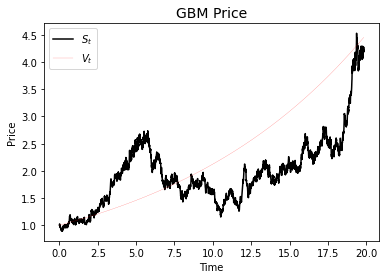

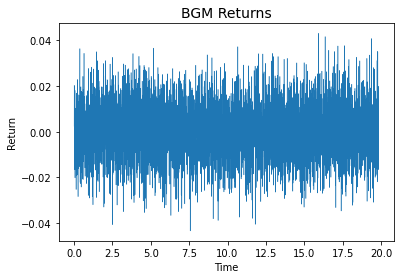

In [9]:
plt.plot(tvec, svec, 'k', label='$S_t$')
plt.plot(tvec, vvec, 'r', label='$V_t$', linewidth=0.15)
plt.title('GBM Price', size=14)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.plot(tvec[1:], r_gbm, linewidth=0.5)
plt.title('BGM Returns', size=14)
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

### ACF Plots

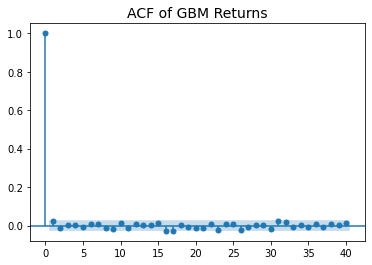

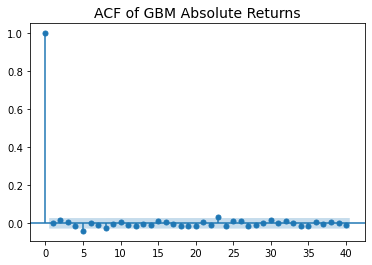

In [10]:
plot_acfs(r_gbm, 'GBM')

### GBM Summary Statistics

In [11]:
(mu_gbm, sigma_gbm, skew_gbm, kurt_gbm, range_gbm, acf_rabs_gbm) = print_stats(r_gbm)

Daily return statistics:
Mean:			 0.0002870875679817699
Std dev:		 0.012443720022735558
Variance:		 0.00015484616800422985
Skewness:		 -0.021154824123926812
Excess kurt:		 -0.06371466769546164
Range:			 0.08666623797442163

Annualized return statistics:
Mean (mu):		 0.07234606713140601
Std dev (sigma):	 0.19753793138803982
Variance:		 0.03902123433706592

Average 3-lag ACF
|acf(r)|:		 0.012851404303503308
acf(|r|):		 0.00804249968444227

Jarque-Berra:		 Jarque_beraResult(statistic=1.2186802530000547, pvalue=0.543709530236673)
Ljung-Box r (5, 10, 15):
 (array([ 4.08184698,  8.55547088, 10.73532373]), array([0.53769324, 0.57474476, 0.77112122]))
Ljung-Box |r| (5, 10, 15):
 (array([10.12510647, 13.91012196, 16.89868382]), array([0.07176703, 0.17713084, 0.32495711]))
Ljung-Box r^2 (5, 10, 15):
 (array([ 9.06946277, 11.9404231 , 14.42404369]), array([0.10632539, 0.28906356, 0.49364197]))


## Agent-Based Dynamical Systems Model (ABM)

In [12]:
def initialize(init_alpha, init_beta, init_nu1dt, init_nu2dt, sim_len, init_seed):
    global s, v, Nf, Nc, No, Np, N, x, t, svec, vvec, yfvec, ycvec, yovec, ypvec, xvec, tvec, traders
    global alpha, beta, mu, nu1, nu2, lamb, T, dt
    
    if init_seed is not None:
        random.seed(init_seed)

    dt = 1./252         # 252 trading days in a year
    T =  sim_len * dt   # simulation length in years

    N = 200             # total number of traders
    Nf = N//2           # number of fundamentalist traders
    Nc = N - Nf         # number of noise traders

    alpha = 800.        # size of trades made by fundamentalist traders
    beta = 200.         # size of trades made by noise traders

    mu = mu_h           # annual growth of pf - taken from historical returns above

    nu1 = 0.5/dt        # parameter for optimist/pessimist transition probabilities
    nu2 = 0.003/dt      # parameter for fundamentalist/noise trader transition probabilities

    lamb = 6.9

    if init_alpha is not None:
        alpha = init_alpha
    if init_beta is not None:
        beta = init_beta
    if init_nu1dt is not None:
        nu1 = init_nu1dt/dt
    if init_nu2dt is not None:
        nu2 = init_nu2dt/dt

    v = 1.0
    s = v
   
    traders = np.zeros([1,N])
    for i in range(N):
        if i < Nc:       # noise trader
            traders[0, i] = random.randint(0, 2) # 0 (pessimist) or 1 (optimist)
        else:
            traders[0, i] = 2                    # fundamentalist

    Np = len(traders[0, traders[0,:] == 0])  # pessimist = 0
    No = len(traders[0, traders[0,:] == 1])  # optimist = 1
    Nf = len(traders[0, traders[0,:] == 2])  # fundamentalist = 2
    Nc = Np + No
    
    x = (No - Np) / Nc
    t = 0.
    
    svec = [s]
    vvec = [v]
    yfvec = [Nf/N]
    ycvec = [Nc/N]
    yovec = [No/N]
    ypvec = [Np/N]
    xvec = [x]
    tvec = [t]

    
def observe():
    global s, v, Nf, Nc, No, Np, N, x, t, svec, vvec, yfvec, ycvec, yovec, ypvec, xvec, tvec, traders
    global alpha, beta, mu, nu1, nu2, lamb, T, dt
    svec.append(s)
    vvec.append(v)
    yfvec.append(Nf/N)
    ycvec.append(Nc/N)
    yovec.append(No/N)
    ypvec.append(Np/N)
    xvec.append(x)
    tvec.append(t)


def update(model):
    global s, v, Nf, Nc, No, Np, N, x, t, svec, vvec, yfvec, ycvec, yovec, ypvec, xvec, tvec, traders
    global alpha, beta, mu, nu1, nu2, lamb, T, dt

    if model == 1:     # proposed model
        drift = min(alpha*Nf/N*dt,1)*(v - s)     # avoid numerical instability from Euler discretization
        shock = beta*Np/N*s*x*dt
    elif model == 2:   # baseline model
        drift = min(alpha*Nf/N*s*dt,1)*(v - s)   # avoid numerical instability from Euler discretization
        shock = beta*Nc/N*s*x*dt
        
    ns = s + drift + shock 
    if ns < 0.:
        ns = 0.
        
    p_op = nu1*dt*Np/Nc      # probability that optimist switches to pessimist
    p_po = nu1*dt*No/Nc      # probability that pessimist switches to optimist
    
    if (p_op < 0 or p_op > 1 or p_po < 0 or p_po > 1):
        print(p_op, p_po, Nf, Nc, Np, No, s, v, x, ns)
        
    optim = random.binomial(1, 1 - p_op, N)   # 1 - p_o is probability of staying an optimist
    pessim = random.binomial(1, p_po, N)      # p_p is probability of switching to optimist
    
    if model == 1:
        rho = abs(s-v)/v
        p_fn = nu2*dt*np.exp(-lamb*rho)       # probability that fundamentalist switches to noise
        p_nf = nu2*dt*(1 - np.exp(-lamb*rho)) # probability that noise switches to fundamentalist

        if (p_fn < 0 or p_fn > 1 or p_nf < 0 or p_nf > 1):
            print(p_fn, p_nf, Nf, Nc, Np, No, s, v, x, ns, rho)

        funda = random.binomial(1, p_nf, N)  # p_nf is probability of switching to fundamentalist  
        noise = random.binomial(1, p_fn, N)  # p_fn is probability of switching to noise
    else:
        funda = np.zeros(N)
        noise = np.zeros(N)

    for i in range(N):
        if traders[0, i] == 2:                # fundamentalist
            if model == 1 and noise[i] == 1 and Nf > 1:
                traders[0, i] = random.randint(0, 2)  # switch to noise
                Nf -= 1
        elif model == 1 and funda[i] == 1:    # noise trader switches to fundamentalist
            if Nc > 1:
                traders[0, i] = 2;
                Nc -= 1
        elif traders[0, i] == 1:              # optimist
            traders[0, i] = optim[i]
        else:                                 # pessimist
            traders[0, i] = pessim[i]

    nNf = len(traders[0, traders[0,:] == 2])
    nNo = len(traders[0, traders[0,:] == 1])
    nNp = len(traders[0, traders[0,:] == 0])
    nNc = nNp + nNo
    if nNp < 1:      # Np = 0 is an absorbing state, so implement refecting boundary
        nNp = 1
        nNo = nNc - 1
    if nNo < 1:      # No = 0 is an absorbing state, so implement refecting boundary
        nNo = 1
        nNp = nNc - 1
        
    nx = (nNo - nNp) / nNc

    nv = v + mu*v*dt
    
    t = t + dt
    
    s, v, Nf, Nc, No, Np, x = ns, nv, nNf, nNc, nNo, nNp, nx
    
    observe()
    
    
def run_abm(init_alpha, init_beta, init_nu1dt, init_nu2dt, sim_len, init_seed, model = 1):
    global t, dt, T
    if model != 1:
        init_nu2dt = 0.
    initialize(init_alpha, init_beta, init_nu1dt, init_nu2dt, sim_len, init_seed)
    while t < (T-dt):
        update(model)

### ABM Calibration (Parameter sweep)

In [13]:
t0 = time.time()

init_seed = 100
num_seeds = 10

file_name = 'market_abm.csv'
try:
    open(file_name)
    os.remove(file_name)
except:
    pass

fout = open(file_name, 'w')
fout.write('alpha, beta, nu1dt, nu2dt, ')
for i in range(num_seeds):
    fout.write('seed, mu, sigma, skew, kurt, range, acf_r, acf_rabs, sse, ')
fout.write('avg sse\n')
fout.flush()

models = []
class model:
    pass
class model_stats:
    pass

for alpha in [800.]:
    for beta in np.linspace(100., 400., 13):
        for nu1dt in np.linspace(0.1, 0.9, 9):
            for nu2dt in [0.003]:
        
                mdl = model()
                mdl.alpha = alpha
                mdl.beta = beta
                mdl.nu1dt = nu1dt
                mdl.nu2dt = nu2dt
                mdl.stats = []
                
                fout.write('%f, %f, %f, %f, ' % (alpha, beta, nu1dt, nu2dt))
                
                sse_list = []
                for s_i in range(init_seed, init_seed+num_seeds):
                
                    run_abm(alpha, beta, nu1dt, nu2dt, init_seed=s_i, sim_len=6000)

                    svec = svec[1000:]
                    r = np.diff(np.log(svec))

                    mu = np.mean(r) * 252
                    sigma = np.std(r) * np.sqrt(252)
                    skew = stats.skew(r)
                    kurt = stats.kurtosis(r)
                    rng = r.max() - r.min()
                    acf_r = np.average(np.abs(sm.tsa.acf(r))[1:4])    # should be close to zero
                    acf_rabs = np.average(sm.tsa.acf(np.abs(r))[1:4]) # should be close to 0.4
                    jb = stats.jarque_bera(r)[0]
                    lb15 = sm.stats.acorr_ljungbox(r**2, lags=[15])[0][0]

                    se_mu = ((mu - mu_h)/mu_h)**2
                    se_stdev = ((sigma - sigma_h)/sigma_h)**2
                    se_skew = ((skew - skew_h)/skew_h)**2
                    se_kurt = ((kurt - kurt_h)/kurt_h)**2
                    se_rng = ((rng - rng_h)/rng_h)**2
                    se_acf_r = acf_r**2
                    se_acf_rabs = ((acf_rabs - acf_rabs_h)/acf_rabs_h)**2
                
                    weights = [10.,
                               0.1,
                               1.,
                               0.1,
                               10.,
                               1.]

                    se = [se_stdev,
                          se_skew,
                          se_kurt,
                          se_rng,
                          se_acf_r,
                          se_acf_rabs]

                    sse = np.sum([w * x for w, x in zip(weights, se)])

                    mdl_stats = model_stats()
                    mdl_stats.seed = s_i
                    mdl_stats.mu = mu
                    mdl_stats.sigma = sigma
                    mdl_stats.skew = skew
                    mdl_stats.kurt = kurt
                    mdl_stats.rng = rng
                    mdl_stats.acf_r = acf_r
                    mdl_stats.acf_rabs = acf_rabs
                    mdl_stats.jb = jb
                    mdl_stats.lb = lb15

                    mdl_stats.wse = [w * x for w, x in zip(weights, se)]
                    mdl_stats.sse = sse
                    
                    mdl.stats.append(mdl_stats)

                    sse_list.append(sse)

                    sse_out = 999.9
                    if np.isfinite(sse):
                        sse_out = sse

                    fout.write('%d, %.12lf, %.12lf, %.12lf, %.12lf, %.12lf, %.12lf, %.12lf, ' %
                               (s_i, mu, sigma, skew, kurt, rng, acf_r, acf_rabs))
                    fout.write('%.12lf, ' % sse_out)


                mdl.sse = np.mean(sse_list)
                if np.isfinite(mdl.sse):
                    models.append(mdl)

                sse_out = 999.9
                if np.isfinite(mdl.sse):
                    sse_out = mdl.sse

                fout.write('%.12lf\n' % sse_out)
                fout.flush()

fout.close()

t1 = time.time()
print('Total time: %.f sec' % (t1-t0))

Total time: 1503 sec


### Find Optimal Model

In [14]:
i_min = np.argmin([m.sse for m in models])
opt_model = models[i_min]
vars(opt_model)

{'alpha': 800.0,
 'beta': 150.0,
 'nu1dt': 0.7000000000000001,
 'nu2dt': 0.003,
 'stats': [<__main__.model_stats at 0x1e38c7748e0>,
 'sse': 0.5194441130097868}

In [15]:
i_min = np.argmin([st.sse for st in opt_model.stats])
opt_stats = opt_model.stats[i_min]
vars(opt_stats)

{'seed': 108,
 'mu': 0.06967027621864488,
 'sigma': 0.19404641225942343,
 'skew': -0.6024006002409292,
 'kurt': 8.242688944113757,
 'rng': 0.18195603925229026,
 'acf_r': 0.024715487221496774,
 'acf_rabs': 0.4019910847629262,
 'jb': 14456.972283770352,
 'lb': 2748.0914155703667,
 'wse': [0.0016519729944056006,
  0.09768510362584634,
  0.1302900469959216,
  0.007640419361518533,
  0.006108553085959703,
  0.008178263178744821],
 'sse': 0.2515543592423966}

### Plot ABM Price and Returns

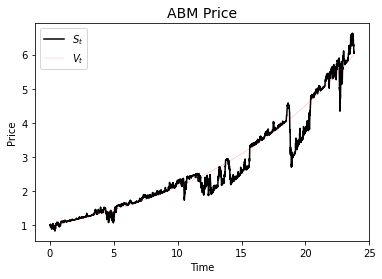

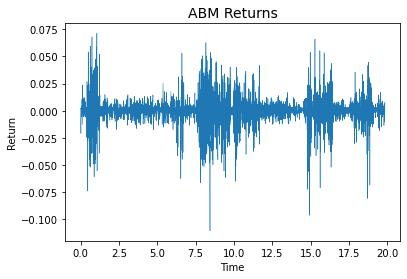

In [16]:
run_abm(opt_model.alpha, opt_model.beta, opt_model.nu1dt, opt_model.nu2dt, sim_len = 6000, init_seed=opt_stats.seed)
                    
plt.plot(tvec, svec, 'k', label='$S_t$')
plt.plot(tvec, vvec, 'r', label='$V_t$', linewidth=0.15)
plt.title('ABM Price', size=14)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

r_abm = np.diff(np.log(svec[1000:]))

plt.plot(tvec[:len(r_abm)], r_abm, linewidth=0.5)
plt.title('ABM Returns', size=14)
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

### ACF Plots

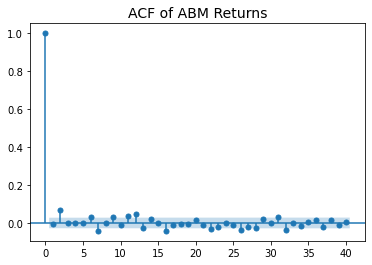

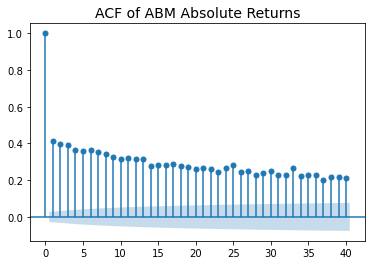

In [17]:
plot_acfs(r_abm, 'ABM')

### Summary Statistics

In [18]:
(mu_abm, sigma_abm, skew_abm, kurt_abm, range_abm, acf_rabs_abm) = print_stats(r_abm)

Daily return statistics:
Mean:			 0.00027646935007398765
Std dev:		 0.012223774991494038
Variance:		 0.00014942067504267504
Skewness:		 -0.6024006002409292
Excess kurt:		 8.242688944113757
Range:			 0.18195603925229026

Annualized return statistics:
Mean (mu):		 0.06967027621864488
Std dev (sigma):	 0.19404641225942343
Variance:		 0.03765401011075411

Average 3-lag ACF
|acf(r)|:		 0.024715487221496774
acf(|r|):		 0.4019910847629262

Jarque-Berra:		 Jarque_beraResult(statistic=14456.972283770352, pvalue=0.0)
Ljung-Box r (5, 10, 15):
 (array([22.56841602, 41.47200083, 65.70054871]), array([4.08100710e-04, 9.30697681e-06, 2.57463619e-08]))
Ljung-Box |r| (5, 10, 15):
 (array([3733.30776647, 6648.10547207, 8963.58782982]), array([0., 0., 0.]))
Ljung-Box r^2 (5, 10, 15):
 (array([1078.72332125, 2008.78423296, 2748.09141557]), array([5.41499663e-231, 0.00000000e+000, 0.00000000e+000]))


### ABM Visualization

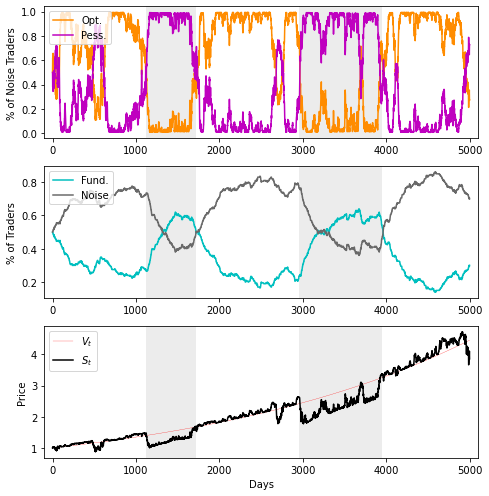

In [19]:
run_abm(opt_model.alpha, opt_model.beta, opt_model.nu1dt, opt_model.nu2dt, sim_len = 6000, init_seed=opt_model.stats[0].seed)

fig = plt.figure(figsize=[7,7])
ax1 = plt.subplot(3, 1, 1)
plt.plot([x/y for x,y in zip(yovec[:hist_size], ycvec[:hist_size])], 'darkorange', label='Opt.')
plt.plot([x/y for x,y in zip(ypvec[:hist_size], ycvec[:hist_size])], 'm', label='Pess.')
plt.ylabel('% of Noise Traders')
plt.xlim(-100,hist_size+100)
plt.legend(loc ='upper left')

ax2 = plt.subplot(3, 1, 2)
plt.plot(yfvec[:hist_size], 'c', label='Fund.')
plt.plot(ycvec[:hist_size], 'dimgray', label='Noise')
plt.ylabel('% of Traders')
plt.xlim(-100,hist_size+100)
plt.legend(loc ='upper left')

ax3 = plt.subplot(3, 1, 3)
plt.plot(vvec[:hist_size], 'r', label='$V_t$', linewidth=0.25)
plt.plot(svec[:hist_size], 'k',label='$S_t$')
plt.ylabel('Price')
plt.xlim(-100,hist_size+100)
plt.legend(loc ='upper left')
plt.xlabel('Days')

ax1.axvspan(1120, 1720, facecolor='gray', alpha=0.15)
ax2.axvspan(1120, 1720, facecolor='gray', alpha=0.15)
ax3.axvspan(1120, 1720, facecolor='gray', alpha=0.15)

ax1.axvspan(2960, 3950, facecolor='gray', alpha=0.15)
ax2.axvspan(2960, 3950, facecolor='gray', alpha=0.15)
ax3.axvspan(2960, 3950, facecolor='gray', alpha=0.15)

fig.tight_layout()

plt.savefig('abm-visual.png', dpi=300)

plt.show()

## Plots for paper

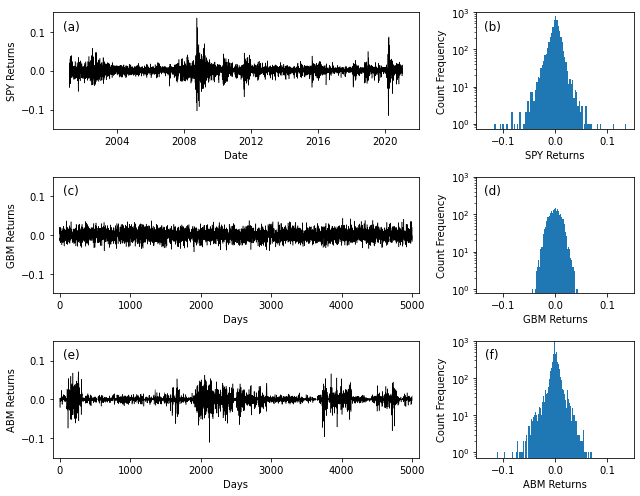

In [20]:
# Plot returns of all three

import matplotlib.dates as mdates

plt.figure(figsize=[9,7])

gs = gridspec.GridSpec(3, 2, width_ratios=[7, 3]) 

ax = plt.subplot(gs[0])
plt.plot(df['Date'], df['Return'], linewidth=0.5, color='k')
#plt.plot(r_hist, linewidth=0.5, color='k', label='B')
plt.ylabel('SPY Returns')
plt.xlabel('Date')
#plt.xlim(-100,5100)
plt.ylim(-0.15, 0.15)
ax.set_title('(a)', x=0.05, y=0.97, pad=-14)

ax = plt.subplot(gs[1])
#sgt.plot_acf(np.abs(r_hist), lags=40, zero=True, ax=ax1)
plt.hist(r_hist, bins=100)
plt.ylabel('Count Frequency')
plt.xlabel('SPY Returns')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.15, 0.15)
plt.ylim(0., 1000)
ax.set_title('(b)', x=0.1, y=0.97, pad=-14)

ax = plt.subplot(gs[2])
plt.plot(r_gbm, linewidth=0.5, color='k', label='B')
plt.ylabel('GBM Returns')
plt.xlabel('Days')
plt.title('(c)')
plt.xlim(-100,5100)
plt.ylim(-0.15, 0.15)
ax.set_title('(c)', x=0.05, y=0.97, pad=-14)

ax = plt.subplot(gs[3])
plt.hist(r_gbm, bins=100)
plt.ylabel('Count Frequency')
plt.xlabel('GBM Returns')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.15, 0.15)
plt.ylim(0., 1000)
ax.set_title('(d)', x=0.1, y=0.97, pad=-14)

ax = plt.subplot(gs[4])
plt.plot(r_abm, linewidth=0.5, color='k')
plt.ylabel('ABM Returns')
plt.xlabel('Days')
plt.xlim(-100,5100)
plt.ylim(-0.15, 0.15)
ax.set_title('(e)', x=0.05, y=0.97, pad=-14)

ax = plt.subplot(gs[5])
plt.hist(r_abm, bins=100)
plt.ylabel('Count Frequency')
plt.xlabel('ABM Returns')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.15, 0.15)
plt.ylim(0., 1000)
ax.set_title('(f)', x=0.1, y=0.97, pad=-14)

plt.tight_layout()

plt.savefig('returns-hist.png', dpi=300)

plt.show()

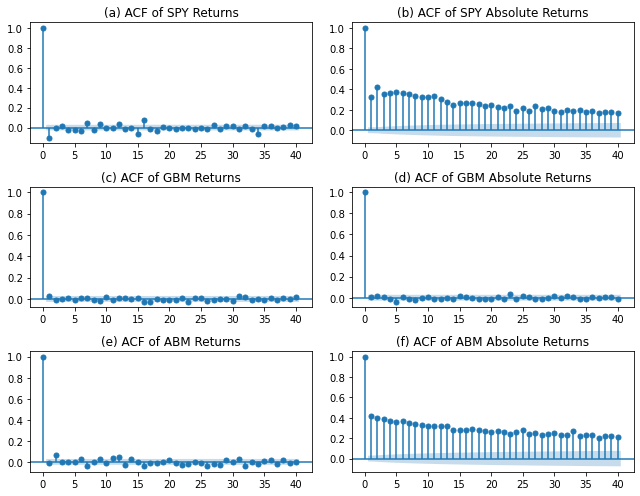

In [21]:
# Plot ACFs of all three

plt.figure(figsize=[9,7])

gs = gridspec.GridSpec(3, 2) 

ax = plt.subplot(gs[0])
sgt.plot_acf(r_hist, lags=40, zero=True, ax=ax)
plt.yticks(np.linspace(0., 1., 6))
plt.title('(a) ACF of SPY Returns')

ax = plt.subplot(gs[1])
sgt.plot_acf(np.abs(r_hist), lags=40, zero=True, ax=ax)
plt.title('(b) ACF of SPY Absolute Returns')

ax = plt.subplot(gs[2])
sgt.plot_acf(r_gbm, lags=40, zero=True, ax=ax)
plt.yticks(np.linspace(0., 1., 6))
plt.title('(c) ACF of GBM Returns')

ax = plt.subplot(gs[3])
sgt.plot_acf(np.abs(r_gbm), lags=40, zero=True, ax=ax)
plt.title('(d) ACF of GBM Absolute Returns')

ax = plt.subplot(gs[4])
sgt.plot_acf(r_abm, lags=40, zero=True, ax=ax)
plt.yticks(np.linspace(0., 1., 6))
plt.title('(e) ACF of ABM Returns')

ax = plt.subplot(gs[5])
sgt.plot_acf(np.abs(r_abm), lags=40, zero=True, ax=ax)
plt.title('(f) ACF of ABM Absolute Returns')

plt.tight_layout()

plt.savefig('returns-acf.png', dpi=300)

plt.show()

In [22]:
muvec = []
sigmavec = []
skewvec = []
kurtvec = []

for i in range(100):
   
    run_abm(opt_model.alpha, opt_model.beta, opt_model.nu1dt, opt_model.nu2dt, sim_len = 6000, init_seed=i)

    svec = svec[1000:]
    r = np.diff(np.log(svec))

    muvec.append(np.mean(r) * 252)
    sigmavec.append(np.std(r) * np.sqrt(252))
    skewvec.append(stats.skew(r))
    kurtvec.append(stats.kurtosis(r))

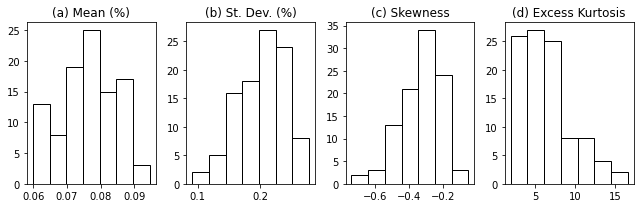

In [23]:
plt.figure(figsize=[9,3])

gs = gridspec.GridSpec(1, 4) 

ax = plt.subplot(gs[0])
plt.hist(muvec, fill=False, bins=7)
plt.title('(a) Mean (%)')

ax = plt.subplot(gs[1])
plt.hist(sigmavec, fill=False, bins=7)
plt.title('(b) St. Dev. (%)')

ax = plt.subplot(gs[2])
plt.hist(skewvec, fill=False, bins=7)
plt.title('(c) Skewness')

ax = plt.subplot(gs[3])
plt.hist(kurtvec, fill=False, bins=7)
plt.title('(d) Excess Kurtosis')

plt.tight_layout()

plt.savefig('sim-hist.png', dpi=300)

plt.show()

In [24]:
def print_sim_stats(vec, name):
    vecavg = np.mean(vec)
    vecstdev = np.std(vec)
    vecmin = np.min(vec)
    vecmax = np.max(vec)

    vecse = stats.sem(vec, axis=0)
    ci = stats.t.interval(alpha=0.95, df=len(vec)-1, loc=vecavg, scale=vecse)

    print('%s statistics:' % name)
    print('Avg:\t\t', vecavg)
    print('CI:\t\t', ci)
    print('Std dev:\t', vecstdev)    
    print('Min:\t\t', vecmin)
    print('Max:\t\t', vecmax)
    print()

print_sim_stats(muvec, 'Mean')
print_sim_stats(sigmavec, 'Standard Deviation')
print_sim_stats(skewvec, 'Skewness')
print_sim_stats(kurtvec, 'Excess Kutosis')

Mean statistics:
Avg:		 0.07641248791909615
CI:		 (0.07473262671344548, 0.07809234912474682)
Std dev:	 0.008423679650727378
Min:		 0.059804433102731404
Max:		 0.0946841284412819

Standard Deviation statistics:
Avg:		 0.20211588144428957
CI:		 (0.1943639858494304, 0.20986777703914875)
Std dev:	 0.03887195260973094
Min:		 0.09084675851975432
Max:		 0.279162702738012

Skewness statistics:
Avg:		 -0.3255821720723578
CI:		 (-0.3508914918512352, -0.3002728522934804)
Std dev:	 0.12691381959291217
Min:		 -0.7398719813711945
Max:		 -0.047014693136173354

Excess Kutosis statistics:
Avg:		 6.369356716695892
CI:		 (5.745767094126684, 6.9929463392650995)
Std dev:	 3.126995966316366
Min:		 1.9537067128700993
Max:		 16.579354103201034

